packageのインストール方法
juliaを別途ターミナルから立ち上げて以下を入力

```
$ julia
julia> ここで]をおしてパッケージ管理モードに入る
(@v1.8) pkg> add CUDA Plots Revise
(@v1.8) pkg> add https://github.com/matsunagalab/MDToolbox.jl.git
(@v1.8) pkg> deleteをおしてパッケージ管理モードを抜ける
julia> Ctrl-dをおしてjuliaを終了
```

In [1]:
using CUDA
#using HTTP
using DelimitedFiles
using Plots
using ChainRulesCore
using ProgressMeter
using Revise
using MDToolbox

In [2]:
function set_charge(ta::TrjArray{T,U}) where {T,U}
    charge = Array{Int64}(undef, ta.natom)
    
    atomname = deepcopy(ta.atomname)
    
    is_first = true
    
    for iatom = 1:ta.natom
        # ATOM TYPE "N"
        if ta.atomname[iatom] == "N"
            if is_first
                charge[iatom] = 1
                is_first = false
            else
                charge[iatom] = 11
            end

            # ATOM TYPE "O"
        elseif ta.resname[iatom] == "O"
            charge[iatom] = 10
        elseif ta.resname[iatom] == "OXT"
            charge[iatom] = 2

        elseif ta.resname[iatom] == "ARG" && atomname[iatom] == "NH1"
            charge[iatom] = 3
        elseif ta.resname[iatom] == "ARG" && atomname[iatom] == "NH2"
            charge[iatom] = 3
        elseif ta.resname[iatom] == "GLU" && atomname[iatom] == "OE1"
            charge[iatom] = 4
        elseif ta.resname[iatom] == "GLU" && atomname[iatom] == "OE2"
            charge[iatom] = 4
        elseif ta.resname[iatom] == "ASP" && atomname[iatom] == "OD1"
            charge[iatom] = 5
        elseif ta.resname[iatom] == "ASP" && atomname[iatom] == "OD2"
            charge[iatom] = 5
        elseif ta.resname[iatom] == "LYS" && atomname[iatom] == "NZ"
            charge[iatom] = 6
        elseif ta.resname[iatom] == "PRO" && atomname[iatom] == "N"
            charge[iatom] = 7

        else
            charge[iatom] = 8
        
        end
    end
    
    return TrjArray(ta, charge=charge)
end

function get_charge_score()
    charge_score = Array{Float64}(undef, 11)
    charge_score[1] = 1.0 #TERMINAL-N
    charge_score[2] = -1.0 #TERMINAL-O
    charge_score[3] = 0.5 #ARG,NH
    charge_score[4] = -0.5 #GLU,OE
    charge_score[5] = -0.5 #ASP,OD
    charge_score[6] = 1.0 #LYS,NZ
    charge_score[7] = -0.1 #PRO,N
    charge_score[8] = 0.0 #CA
    charge_score[9] = 0.0 #C
    charge_score[10] = -0.5 #O
    charge_score[11] = 0.5 #N
    
    return charge_score
end

function assign_Li_charge!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_real .= zero(T)

    spread_nearest_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, charge_score)
    return nothing
end

function assign_Re_charge!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_real .= zero(T)

    spread_nearest_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, charge_score)
    return nothing
end

# function spread_neighbors_add_potential!(grid::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T}

#     natom = length(x)
#     nx, ny, nz = size(grid)
#     for iatom = 1:natom
#         for ix = 1:nx
#             dx = x[iatom] - x_grid[ix]
#             if abs(dx) > rcut[iatom]
#                 continue
#             end
#             for iy = 1:ny
#                 dy = y[iatom] - y_grid[iy]
#                 if abs(dy) > rcut[iatom]
#                     continue
#                 end
#                 for iz = 1:nz
#                     dz = z[iatom] - z_grid[iz]
#                     if abs(dz) > rcut[iatom]
#                         continue
#                     end
#                     d = dx * dx + dy * dy + dz * dz
#                     if d < rcut[iatom] * rcut[iatom]
#                         grid[ix, iy, iz] += weight[iatom]　/ sqrt(d)
#                     end
#                 end
#             end
#         end
#     end

#     return nothing
# end

function calculate_distance!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T}
    
    grid .= zero(T)
    
    natom = length(x)
    nx, ny, nz = size(grid)
    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] += sqrt(d)
                    end
                end
            end
        end
    end
    
    return nothing
end

function assign_Re_potential!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_charge = similar(grid_imag)
    grid_dis = similar(grid_imag)
    
    
    grid_charge .= zero(T)
    grid_dis .= zero(T)
    
    rcut = similar(charge_score)
    rcut .= T(8.0)
    
    spread_nearest_add!(grid_charge, x, y, z, x_grid, y_grid, z_grid, charge_score)
    calculate_distance!(grid_dis, x, y, z, x_grid, y_grid, z_grid, charge_score, rcut)
    
    grid_imag = grid_charge ./ grid_dis
    
    return nothing
end

function assign_Li_potential!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_charge = similar(grid_imag)
    grid_dis = similar(grid_imag)
    
    
    grid_charge .= zero(T)
    grid_dis .= zero(T)
    
    rcut = similar(charge_score)
    rcut .= T(8.0)
    
    spread_nearest_add!(grid_charge, x, y, z, x_grid, y_grid, z_grid, charge_score)
    calculate_distance!(grid_dis, x, y, z, x_grid, y_grid, z_grid, charge_score, rcut)
    
    grid_imag = grid_charge ./ grid_dis
    
    return nothing
end

assign_Li_potential! (generic function with 1 method)

In [3]:

################ grid

function generate_grid(receptor_org::TrjArray{T,U}, ligand_org::TrjArray{T,U}; iframe=1, spacing=1.2) where {T,U}
    receptor = deepcopy(receptor_org)
    ligand = deepcopy(ligand_org)
    decenter!(receptor)
    orient!(ligand)
    xmin_ligand = minimum(ligand.xyz[iframe, 1:3:end])
    xmax_ligand = maximum(ligand.xyz[iframe, 1:3:end])
    size_ligand = xmax_ligand - xmin_ligand

    xmin_receptor = minimum(receptor.xyz[iframe, 1:3:end])
    xmax_receptor = maximum(receptor.xyz[iframe, 1:3:end])
    xmin_grid = xmin_receptor - size_ligand - spacing
    xmax_grid = xmax_receptor + size_ligand + spacing

    ymin_receptor = minimum(receptor.xyz[iframe, 2:3:end])
    ymax_receptor = maximum(receptor.xyz[iframe, 2:3:end])
    ymin_grid = ymin_receptor - size_ligand - spacing
    ymax_grid = ymax_receptor + size_ligand + spacing

    zmin_receptor = minimum(receptor.xyz[iframe, 3:3:end])
    zmax_receptor = maximum(receptor.xyz[iframe, 3:3:end])
    zmin_grid = zmin_receptor - size_ligand - spacing
    zmax_grid = zmax_receptor + size_ligand + spacing

    x_grid = Array{T,1}(range(xmin_grid, xmax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        x_grid = CuArray(x_grid)
    end

    y_grid = Array{T,1}(range(ymin_grid, ymax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        y_grid = CuArray(y_grid)
    end

    z_grid = Array{T,1}(range(zmin_grid, zmax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        z_grid = CuArray(z_grid)
    end

    nx = length(x_grid)
    ny = length(y_grid)
    nz = length(z_grid)

    grid_real = similar(receptor_org.xyz, (nx, ny, nz))
    grid_real .= zero(T)
    grid_imag = similar(receptor_org.xyz, (nx, ny, nz))
    grid_imag .= zero(T)

    return grid_real, grid_imag, x_grid, y_grid, z_grid
end

function spread_nearest_add!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}) where {T}

    natom = length(x)
    x_grid_delta = x_grid[2] - x_grid[1]
    y_grid_delta = y_grid[2] - y_grid[1]
    z_grid_delta = z_grid[2] - z_grid[1]

    x_grid_min = x_grid[1]
    y_grid_min = y_grid[1]
    z_grid_min = z_grid[1]

    for iatom = 1:natom
        ix = ceil(Int, (x[iatom] - x_grid_min) / x_grid_delta)
        iy = ceil(Int, (y[iatom] - y_grid_min) / y_grid_delta)
        iz = ceil(Int, (z[iatom] - z_grid_min) / z_grid_delta)
        grid[ix, iy, iz] += weight[iatom]
    end

    return nothing
end

function spread_nearest_substitute!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}) where {T}

    natom = length(x)
    x_grid_delta = x_grid[2] - x_grid[1]
    y_grid_delta = y_grid[2] - y_grid[1]
    z_grid_delta = z_grid[2] - z_grid[1]

    x_grid_min = x_grid[1]
    y_grid_min = y_grid[1]
    z_grid_min = z_grid[1]

    for iatom = 1:natom
        ix = ceil(Int, (x[iatom] - x_grid_min) / x_grid_delta)
        iy = ceil(Int, (y[iatom] - y_grid_min) / y_grid_delta)
        iz = ceil(Int, (z[iatom] - z_grid_min) / z_grid_delta)
        grid[ix, iy, iz] = weight[iatom]
    end

    return nothing
end

function spread_neighbors_add!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T}

    natom = length(x)
    nx, ny, nz = size(grid)
    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] += weight[iatom]
                    end
                end
            end
        end
    end

    return nothing
end


function spread_neighbors_substitute!(grid::AbstractArray{T2},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T2,T}

    natom = length(x)
    nx, ny, nz = size(grid)

    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] = weight[iatom]
                    end
                end
            end
        end
    end

    return nothing
end


#####################################################

function assign_sc_receptor_plus!(grid_real::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_real .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end

function assign_sc_ligand_plus!(grid_real::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_real .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end

function assign_sc_receptor_minus!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_imag .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(3.5)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end
    
function assign_sc_ligand_minus!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_imag .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(3.5)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end
###################################################

# function assign_sc_receptor!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     x_s = x[id_surface]
#     y_s = y[id_surface]
#     z_s = z[id_surface]
#     radius_s = radius[id_surface]
#     weight_s = similar(radius_s)

#     x_c = x[.!id_surface]
#     y_c = y[.!id_surface]
#     z_c = z[.!id_surface]
#     radius_c = radius[.!id_surface]
#     weight_c = similar(radius_c)

#     weight_s .= T(1.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
#     weight_s .= T(0.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
#     weight_c .= T(0.0)
#     spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))

#     weight_s .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
#     weight_c .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
#     return nothing
# end

# function assign_sc_ligand!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     x_s = x[id_surface]
#     y_s = y[id_surface]
#     z_s = z[id_surface]
#     radius_s = radius[id_surface]
#     weight_s = similar(radius_s)

#     x_c = x[.!id_surface]
#     y_c = y[.!id_surface]
#     z_c = z[.!id_surface]
#     radius_c = radius[.!id_surface]
#     weight_c = similar(radius_c)
    
#     weight_s .= T(1.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

#     weight_c .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))

#     # check_neighbors_ligand!(grid_real, grid_imag)

#     return nothing
# end

function assign_Rij!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    iface_ij::AbstractVector{T}) where {T}

    grid_real .= zero(T)

    radius = similar(iface_ij)
    radius .= T(6.0)
    spread_neighbors_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, iface_ij, radius)

    return nothing
end

function assign_Li!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T}
    ) where {T}

    grid_real .= zero(T)

    radius = similar(x)
    radius .= T(1.0)
    spread_nearest_substitute!(grid_real, x, y, z, x_grid, y_grid, z_grid, radius)

    return nothing
end

# function assign_ds!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     iface_ij::AbstractVector{T}) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     radius = similar(iface_ij)
#     radius .= T(6.0)
#     spread_neighbors_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, iface_ij, radius)

#     radius .= T(1.0)
#     spread_nearest_substitute!(grid_imag, x, y, z, x_grid, y_grid, z_grid, radius)

#     return nothing
# end

################ docking

function docking_score_elec(receptor_org::TrjArray{T,U},
        ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractArray{T}, 
        beta::T, charge_score::AbstractArray{T}) where {T,U}
    spacing = 3.0
    receptor = deepcopy(receptor_org)
    ligands = deepcopy(ligands_org)

    decenter!(receptor)
    decenter!(ligands)

    grid_real, grid_imag, x_grid, y_grid, z_grid = generate_grid(receptor, ligands, spacing=spacing)
    nxyz = T(prod(size(grid_real)))
    
    grid_iface = similar(grid_real)
    grid_elec = similar(grid_imag)

    com = centerofmass(receptor)
    receptor.xyz[:, 1:3:end] .= receptor.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    receptor.xyz[:, 2:3:end] .= receptor.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    receptor.xyz[:, 3:3:end] .= receptor.xyz[:, 3:3:end] .- com.xyz[:, 3:3]
    ligands.xyz[:, 1:3:end] .= ligands.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    ligands.xyz[:, 2:3:end] .= ligands.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    ligands.xyz[:, 3:3:end] .= ligands.xyz[:, 3:3:end] .- com.xyz[:, 3:3]

    # receptor.mass .= iface_ij[receptor.atomtype_id]
    # ligands.mass .= iface_ij[ligands.atomtype_id]

    x = receptor.xyz[1, 1:3:end]
    y = receptor.xyz[1, 2:3:end]
    z = receptor.xyz[1, 3:3:end]
    id_surface = receptor.sasa .> 1.0
    
#     print(typeof(receptor.xyz),size(receptor.xyz))
#     print(typeof(ligands.xyz),size(ligands.xyz))    
#     print_all!(x, y, z, x_grid, y_grid, z_grid)   
    
     
#     function calculate_atom_distances(receptor::TrjArray{T,U}, ligands::TrjArray{T,U}, 
#             x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T})
#         m, n = length(x), length(y)
#         distances = similar(x, m, n)
#         for i in 1:m
#             for j in 1:n
#                 distances[i, j] = sqrt((receptor.xyz[i, 1] - ligands.xyz[j, 1])^2 +
#                 　　　　　　　　　　　(receptor.xyz[i, 2] - ligands.xyz[j, 2])^2 +
#                                   (receptor.xyz[i, 3] - ligands.xyz[j, 3])^2)
#             end
#         end
 
#         return distances
#     end
    
#     atom_distances = calculate_atom_distances(receptor, ligands, x, y, z)
    

    ##########################################
    
    assign_sc_receptor_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    assign_sc_receptor_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    #assign_sc_receptor!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    grid_sc_receptor = grid_real .+ im .* grid_imag
    
    ##########################################

    # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.mass)
    # grid_ds_receptor = grid_real .+ im .* grid_imag
    
#     print_all!(x, y, z, x_grid, y_grid, z_grid)   

    x = ligands.xyz[1, 1:3:end]
    y = ligands.xyz[1, 2:3:end]
    z = ligands.xyz[1, 3:3:end]

    x2 = receptor.xyz[1, 1:3:end]
    y2 = receptor.xyz[1, 2:3:end]
    z2 = receptor.xyz[1, 3:3:end]

    id_surface = ligands.sasa .> 1.0

    grid_sc_ligand = deepcopy(grid_sc_receptor)
    # grid_iface_ligand = deepcopy(grid_real)
    # grid_iface_receptor = deepcopy(grid_real)
    score_sc = similar(grid_real, ligands.nframe)
    score_iface = similar(grid_real, ligands.nframe)
    score_iface .= zero(T)
    score_elec = similar(grid_real, ligands.nframe)
    score_elec .= zero(T)
    score_total = similar(grid_real, ligands.nframe)

    @showprogress for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]

        ###################################################
        
#         assign_sc_ligand!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
#         grid_sc_ligand .= grid_real .+ im .* grid_imag
#         multi = grid_sc_receptor .* grid_sc_ligand
#         score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi))

        assign_sc_ligand_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        assign_sc_ligand_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        grid_sc_ligand .= grid_real .+ im .* grid_imag 
        multi = grid_sc_receptor .* grid_sc_ligand
        score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi)) 
        
        
        ##################################################        
        
        # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.mass)
        # grid_ds_ligand .= grid_real .+ im .* grid_imag
        # multi = grid_ds_receptor .* grid_ds_ligand
        # score_ds[iframe] = T(0.5) * sum(imag(multi))

        for i = 1:12
            idx = ligands.atomtype_id .== i 
            assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
            grid_iface = grid_real
            for j = 1:12
                k = 12 * (j-1) + i 
                receptor.mass .= iface_ij[k]
                idx = receptor.atomtype_id .== j
                assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                score_iface[iframe] += sum(grid_real .* grid_imag)
            end
        end 
        
        for l = 1:11
            idx = ligands.atomtype_id .== l
            idx2 = receptor.atomtype_id .== l
            ligands.mass .= charge_score[l]
            receptor.mass .= charge_score[l]
            assign_Li_charge!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, ligands.mass[idx])
            assign_Re_potential!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])
            score_elec[iframe] += sum(grid_real .* grid_imag)
            grid_elec = grid_imag            
        end

        score_total[iframe] = alpha .* score_sc[iframe] .+ score_iface[iframe] .+ beta .* score_elec[iframe]
    end

#     print_all!(x, y, z, x_grid, y_grid, z_grid)
    
    return score_total
end


docking_score_elec (generic function with 1 method)

In [4]:
#device!(2)

In [5]:
#CUDA.cu(rand(3,3))

In [6]:
ENV["COLUMNS"]=130; #display width for MDToolbox

# load deocoy structures

In [7]:
ntop = 200

200

In [8]:
pdb = mdload("protein/1ZHI/complex.1.pdb")
receptor_z = pdb[1:1, 1:1658]
ligands_z = pdb[1:1, 1659:end]

for i = 2:ntop
    pdb = mdload("protein/1ZHI/complex.$(i).pdb")
    ligands_z = [ligands_z; pdb[1:1, 1659:end]]
end

In [9]:
d = readdlm("protein/1ZHI/1ZHI.zd3.0.2.fg.fixed.out.rmsds")
rmsds_z = d[1:ntop, 2]

200-element Vector{Float64}:
 25.28
 24.73
 25.59
 26.27
 25.17
 24.58
 25.41
 25.75
 26.31
 25.55
 21.42
 22.44
 26.31
  ⋮
 20.86
 14.15
 16.8
  1.99
 22.94
 14.51
 23.19
 26.53
 25.7
 25.2
 13.41
 11.19

In [10]:
receptor_z

1x1658 TrjArray{Float64, Int64}
| A                          | A                          |  …   A                          | A                          |
| -2ALA                      | -2ALA                      |  …   214PRO                     | 214PRO                     |
| 1N                         | 2CA                        |  …   1657CG                     | 1658CD                     |
|   -40.12     8.75   130.15 |   -39.62    10.13   129.88 |  …     -22.52    59.78    98.39 |   -21.89    58.87    99.42 |

# prepare docking score calculation

In [11]:
# vdW radius
receptor_z = MDToolbox.set_radius(receptor_z)
ligands_z = MDToolbox.set_radius(ligands_z)
# receptor_z = MDToolbox.set_radius(receptor_z)
# ligands_z = MDToolbox.set_radius(ligands_z);

In [12]:
# SASA
receptor_z = MDToolbox.compute_sasa(receptor_z)
ligands_z = MDToolbox.compute_sasa(ligands_z);

In [13]:
# receptor_z = MDToolbox.compute_sasa(receptor_z)
# ligands_z = MDToolbox.compute_sasa(ligands_z);

In [14]:
# IFACE scores
receptor_z = MDToolbox.set_atomtype_id(receptor_z)
ligands_z = MDToolbox.set_atomtype_id(ligands_z)
# receptor_z = MDToolbox.set_atomtype_id(receptor_z)
# ligands_z = MDToolbox.set_atomtype_id(ligands_z)

iface_score = MDToolbox.get_iface_ij()
receptor_z = TrjArray(receptor_z, mass=iface_score[receptor_z.atomtype_id])
ligands_z = TrjArray(ligands_z, mass=iface_score[ligands_z.atomtype_id])
# receptor_z = TrjArray(receptor_z, mass=iface_score[receptor_z.atomtype_id])
# ligands_z = TrjArray(ligands_z, mass=iface_score[ligands_z.atomtype_id]);

In [15]:
# ELEC
receptor_z = set_charge(receptor_z)
ligands_z = set_charge(ligands_z)
# receptor_z = set_charge(receptor_z)
# ligands_z = set_charge(ligands_z)
charge = get_charge_score()
# receptor = TrjArray(receptor, mass=iface_score[receptor.atomtype_id])
# ligands = TrjArray(ligands, mass=charge[ligands.atomtype_id]);

In [16]:
#CUDA.device!(0)

In [17]:
#device!(1)

In [18]:
#gpu(receptor)

In [19]:
#receptor = gpu(receptor)

In [20]:
# if CUDA.functional()
#     receptor = gpu(receptor)
#     ligands = gpu(ligands)
# end

In [21]:
iface_score

12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [22]:
charge

11-element Vector{Float64}:
  1.0
 -1.0
  0.5
 -0.5
 -0.5
  1.0
 -0.1
  0.0
  0.0
 -0.5
  0.5

# perform docking score calculation for decoy structures

In [23]:
iface_trained = [0.731, 0.186, -0.179, 0.465, -0.014, -0.863, -0.929, -0.098, -0.276, -0.232, 1.143, 0.292,
0.186, 0.103, 0.046, 0.173, -0.037, -0.593, -0.343, 0.518, 0.107, -0.246, 0.254, 0.351,
-0.179, 0.046, -0.068, 0.191, -0.222, -0.959, -1.1, 0.826, 0.532, -0.466, 0.518, 0.114,
0.465, 0.173, 0.191, 0.484, 0.116, -0.696, -0.596, 0.592, 0.209, -0.118, 0.786, 0.534,
-0.014, -0.037, -0.222, 0.116, -0.685, -0.976, -1.072, 0.493, 0.411, -0.676, -0.273, -0.184,
-0.863, -0.593, -0.959, -0.696, -0.976, -0.897, -1.707, -0.347, -0.275, -1.469, 0.086, -0.788,
-0.929, -0.343, -1.1, -0.596, -1.072, -1.707, -1.588, 0.283, 0.405, -1.673, 0.503, -0.889,
-0.098, 0.518, 0.826, 0.592, 0.493, -0.347, 0.283, 1.62, 1.29, -0.261, 0.303, 0.594,
-0.276, 0.107, 0.532, 0.209, 0.411, -0.275, 0.405, 1.29, 1.114, -0.134, -0.105, 0.725,
-0.232, -0.246, -0.466, -0.118, -0.676, -1.469, -1.673, -0.261, -0.134, -1.746, 0.059, -0.632,
1.143, 0.254, 0.518, 0.786, -0.273, 0.086, 0.503, 0.303, -0.105, 0.059, 1.868, 1.159,
0.292, 0.351, 0.114, 0.534, -0.184, -0.788, -0.889, 0.594, 0.725, -0.632, 1.159, 0.326]

144-element Vector{Float64}:
  0.731
  0.186
 -0.179
  0.465
 -0.014
 -0.863
 -0.929
 -0.098
 -0.276
 -0.232
  1.143
  0.292
  0.186
  ⋮
  0.292
  0.351
  0.114
  0.534
 -0.184
 -0.788
 -0.889
  0.594
  0.725
 -0.632
  1.159
  0.326

In [24]:
charge_trained = [ 0.8810859017396302, -1.2516117230362345,  0.39169932590646656, -0.541326795421053, -0.6224598989726209, 0.9539005164742509, -0.01595881873387269, -0.03898181360212097, -0.2222235269379909, -0.7621727808113634,  0.22921753387205085]

11-element Vector{Float64}:
  0.8810859017396302
 -1.2516117230362345
  0.39169932590646656
 -0.541326795421053
 -0.6224598989726209
  0.9539005164742509
 -0.01595881873387269
 -0.03898181360212097
 -0.2222235269379909
 -0.7621727808113634
  0.22921753387205085

In [25]:
#current_score = MDToolbox.docking_score(receptor, ligands, 0.01f0, CUDA.cu(iface_score[1:end]))

In [26]:
# current_score_b = MDToolbox.docking_score(receptor, ligands, 0.01, iface_score[1:end])

In [27]:
current_score = MDToolbox.docking_score(receptor_z, ligands_z, 0.01, iface_score[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


200-element Vector{Float64}:
 -1176.402
 -1073.7399999999998
 -1437.6979999999999
 -1591.3309999999992
 -1144.9289999999992
 -1181.533999999999
  -988.7429999999997
 -1586.1709999999996
 -1429.4360000000001
 -1458.8240000000003
 -1349.0430000000001
 -1235.4170000000004
 -1378.351000000001
     ⋮
  -592.0500000000004
  -510.1820000000005
 -2013.0639999999999
 -1554.3119999999992
 -1201.8709999999992
 -2254.596
  -805.2079999999992
 -1411.2980000000005
 -1418.6810000000012
 -1113.539
 -1438.3839999999993
 -2335.922

In [28]:
score_z = docking_score_elec(receptor_z, ligands_z, 0.01, iface_score[1:end], 3.0, charge[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


200-element Vector{Float64}:
 -1706.449825
 -1633.8495499999997
 -1968.5357749999998
 -2093.701899999999
 -1723.344274999999
 -1738.177074999999
 -1493.9643749999998
 -2109.1550499999994
 -2031.4267000000002
 -1998.3523000000005
 -2079.6677250000002
 -1910.5151250000006
 -1929.555675000001
     ⋮
 -1232.5714500000004
 -1387.9928000000007
 -2800.079325
 -2141.1026499999994
 -1929.5510499999991
 -3179.0055500000003
 -1423.7872249999991
 -1991.9118500000006
 -2262.543200000001
 -1782.2981000000002
 -2062.278724999999
 -3309.4141250000002

In [29]:
score_z_trained = docking_score_elec(receptor_z, ligands_z, -0.00278467867962186, iface_trained[1:end], 3.196503671070626, charge_trained[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


200-element Vector{Float64}:
 -1722.5998931927843
 -1702.5584827108084
 -1934.8919569104046
 -2073.153503613329
 -1749.467559918639
 -1791.6394965455718
 -1499.364056131747
 -2114.0962423070014
 -1985.8273289113426
 -2000.962713308857
 -2098.7459480380794
 -1894.2009488399592
 -1961.5267155643733
     ⋮
 -1335.4021908058403
 -1482.5781974934357
 -2659.0435648621506
 -2025.2581054062587
 -1991.803806637998
 -3038.44590163689
 -1423.4004453036441
 -1923.5862492309373
 -2347.17111107429
 -1734.3267187950123
 -1935.1328758498223
 -3262.2252977808575

In [30]:
# current_score_trained_b = MDToolbox.docking_score(receptor, ligands, 0.01, iface_trained[1:end])

In [31]:
# current_score_trained_a = docking_score(receptor, ligands, 0.01, iface_trained[1:end])

In [32]:
# score_elec = docking_score_elec(receptor, ligands, 0.01, iface_trained[1:end], 3.0, charge[1:end])

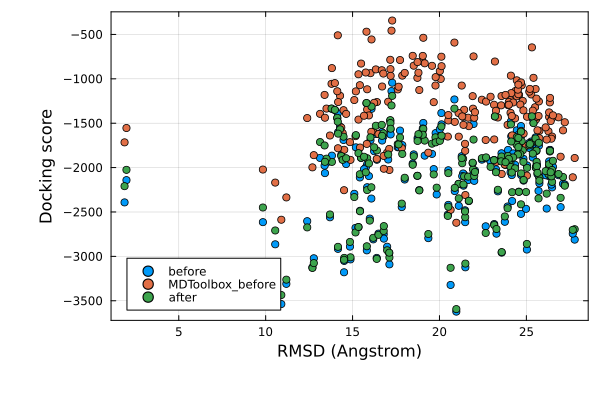

In [33]:
scatter(rmsds_z, score_z, 
        label="before",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_z, current_score, 
        label="MDToolbox_before", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_z, score_z_trained, 
        label="after", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

# create ideal scores as training data

In [34]:
# create training score
x1 = minimum(rmsds_z)
x2 = maximum(rmsds_z)

y1 = maximum(score_z)
y2 = minimum(score_z)

train_score_z = zeros(Float64, ntop)
for i = 1:ntop
    if rmsds_z[i] < 2.5
        train_score_z[i] = y1
    else
        train_score_z[i] = y2
    end     
end

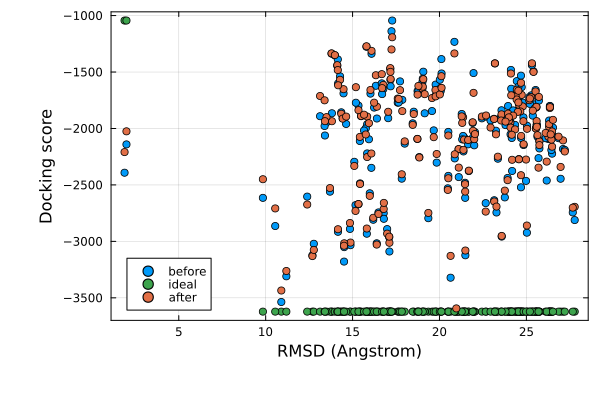

In [35]:
scatter(rmsds_z, score_z, 
        label="before",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_z, train_score_z, 
        label="ideal", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=3,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_z, score_z_trained, 
        label="after", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

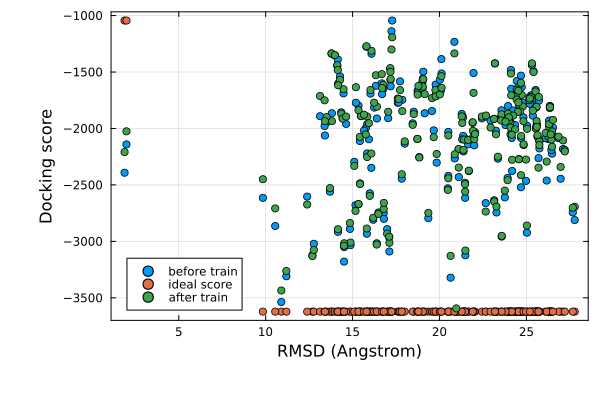

In [36]:
scatter(rmsds_z, score_z, 
        label="before train",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_z, train_score_z, 
        label="ideal score", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_z, score_z_trained, 
        label="after train", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=3,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [37]:
loss_before = sum((score_z - train_score_z).^2) / 100

5.172807002922279e6

In [38]:
loss_after = sum((score_z_trained - train_score_z).^2) / 100

5.212230417220695e6

In [39]:
scatter(rmsds, current_score_b, 
        label="Before SC",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, current_score, 
        label="After SC", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, current_score_trained_b, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, current_score_trained_a, 
        label="After training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

LoadError: UndefVarError: rmsds not defined

# define the docking score function as a layer of neural net framework (Flux.jl)

In [40]:
#ニューラルネットワークフレームワーク(Flux)のレイヤとしてドッキングスコア評価関数を定義

using Flux

struct DockingScore
    A::AbstractArray
    iface_score::AbstractArray
    B::AbstractArray
    charge::AbstractArray
end

DockingScore() = DockingScore(deepcopy([0.01]), deepcopy(iface_score[1:end]), deepcopy([3.0]), deepcopy(charge[1:end]))

Flux.@functor DockingScore (A,iface_score,B,charge)

(m::DockingScore)(x) = docking_score_elec(x[1], x[2], m.A[1], m.iface_score[1:end], m.B[1], m.charge[1:end])

In [41]:
# パラメータとして alpha と aces_core が認識されていることを確認
m = DockingScore()
ps = Flux.params(m)

Params([[0.01], [0.678, 0.133, -0.007, 0.727, 0.091, -0.742, -0.625, -0.064, -0.382, -0.302  …  0.109, 0.477, -0.034, -0.867, -1.04, 0.822, 0.757, -0.572, 0.731, 0.399], [3.0], [1.0, -1.0, 0.5, -0.5, -0.5, 1.0, -0.1, 0.0, 0.0, -0.5, 0.5]])

In [42]:
ps = ps |> Flux.gpu

┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


Params([[0.01], [0.678, 0.133, -0.007, 0.727, 0.091, -0.742, -0.625, -0.064, -0.382, -0.302  …  0.109, 0.477, -0.034, -0.867, -1.04, 0.822, 0.757, -0.572, 0.731, 0.399], [3.0], [1.0, -1.0, 0.5, -0.5, -0.5, 1.0, -0.1, 0.0, 0.0, -0.5, 0.5]])

In [43]:
train_score = train_score_k # + train_score_z 

LoadError: UndefVarError: train_score_k not defined

In [44]:
# 勾配クリッピング関数
function clipgrad!(grads, clip_value=1.0)
    for p in keys(grads)
        g = grads[p]
        if g !== nothing
            grads[p] .= clamp.(g, -clip_value, clip_value)
        end
    end
end

clipgrad! (generic function with 2 methods)

In [45]:
# # 勾配降下法によるパラメータの最適化

# loss(receptor_ligands, train_scores) = sum(Flux.Losses.mse.(m.(receptor_ligands), train_scores)) + 0.001 * sum(Flux.norm, Flux.params(m))

# train_loader = Flux.Data.DataLoader((data=[(receptor_k, ligands_k)], label=[train_score]), batchsize=1, shuffle=false);

# opt = ADAM(1e-5)
   
# loss_train = []
# print("a")
# for epoch in 1:5
#     print("b")
#     for (x, y) in train_loader
#         println("c")
#         gs = gradient(() -> loss(x, y), ps)
#         print("d")
#         Flux.Optimise.update!(opt, ps, gs)
#         print("e")
#     end
#     print("f")
#     push!(loss_train, loss([(receptor_k, ligands_k)], [train_score]))
# end

In [46]:
# 損失関数
function loss(receptor_ligands, train_scores)
    l = sum(Flux.Losses.mse.(m.(receptor_ligands), train_scores)) + 0.001 * sum(Flux.norm, ps)
    return l
end

# データローダーの定義
train_loader = Flux.Data.DataLoader((data=[(receptor_k, ligands_k)], label=[train_score]), batchsize=1, shuffle=false);

# オプティマイザーの定義
opt = ADAM(0.01)

# 損失の記録用リスト
loss_train = []

# 学習率のデバッグ出力
println("Initial learning rate: $(opt.eta)")

# トレーニングループ
for epoch in 1:100
    println("Epoch: $epoch")
    for (x, y) in train_loader
 
        # 勾配の計算
        gs = gradient(() -> loss(x, y), ps)
        
        # 勾配のデバッグ出力
#         println(gs.grads)
        
        # 勾配クリッピング
#         clipgrad!(gs.grads, 1.0)
        
        # パラメータの更新
        Flux.Optimise.update!(opt, ps, gs)
    end
    
    # トレーニング損失の計算
    current_loss = loss([(receptor_k, ligands_k)], [train_score])
    println("Loss: $(current_loss)")
    println("\n")
    push!(loss_train, current_loss)
end

# # 勾配クリッピングの関数
# function clipgrad!(grads, clip_value=1.0)
#     for g in grads
#         if g !== nothing
#             g .= clamp.(g, -clip_value, clip_value)
#         end
#     end
# end

LoadError: UndefVarError: receptor_k not defined

In [47]:
loss_train

LoadError: UndefVarError: loss_train not defined

# visualize the trained results

In [48]:
# 損失関数(Loss function)が学習とともに減少しているか確認
plot(loss_train, 
     linewidth=2, 
     xlabel="Epoch", ylabel="Loss", label=nothing,  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

LoadError: UndefVarError: loss_train not defined

In [49]:
# 学習後のドッキングスコアをプロット
aftertrain_score_k = docking_score_elec(receptor_k, ligands_k, m.A[1], m.iface_score, m.B[1], m.charge)

scatter(rmsds_k, score_k, 
        label="Before training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:topright, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_k, train_score, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_k, aftertrain_score_k, 
        label="After training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=3, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

LoadError: UndefVarError: receptor_k not defined

In [50]:
loss_before = sum((score_k .- train_score).^2) / 100

LoadError: UndefVarError: score_k not defined

In [51]:
loss_after = sum((aftertrain_score_k .- train_score).^2) / 100

LoadError: UndefVarError: aftertrain_score_k not defined

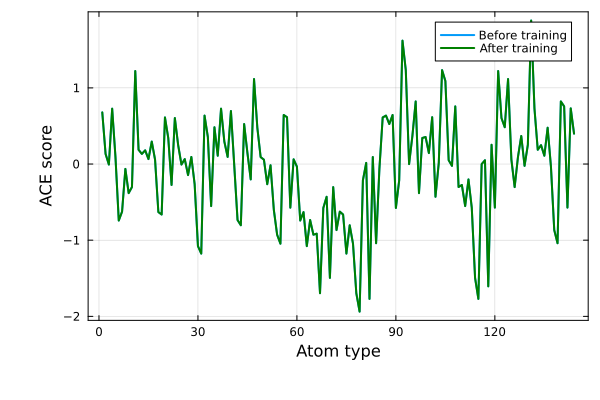

In [52]:
# 学習後の ace_scores をプロット
plot(iface_score[1:end], 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="Before training",  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

plot!(m.iface_score, 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="After training",
     linecolor=:green,
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

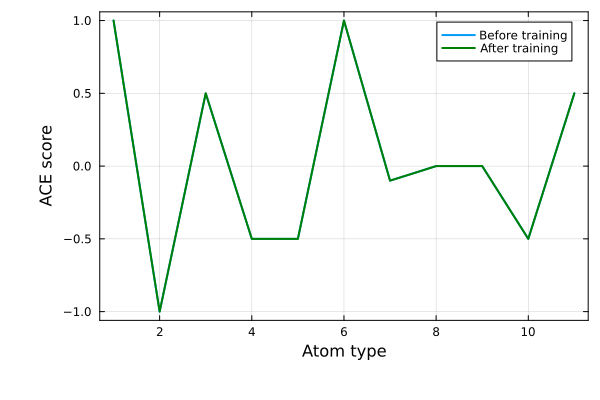

In [53]:
# 学習後の ace_scores をプロット
plot(charge[1:end], 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="Before training",  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

plot!(m.charge, 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="After training",
     linecolor=:green,
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [54]:
charge

11-element Vector{Float64}:
  1.0
 -1.0
  0.5
 -0.5
 -0.5
  1.0
 -0.1
  0.0
  0.0
 -0.5
  0.5

In [55]:
m.charge

11-element Vector{Float64}:
  1.0
 -1.0
  0.5
 -0.5
 -0.5
  1.0
 -0.1
  0.0
  0.0
 -0.5
  0.5

In [56]:
m.iface_score

144-element Vector{Float64}:
  0.678
  0.133
 -0.007
  0.727
  0.091
 -0.742
 -0.625
 -0.064
 -0.382
 -0.302
  1.221
  0.187
  0.133
  ⋮
  0.187
  0.248
  0.109
  0.477
 -0.034
 -0.867
 -1.04
  0.822
  0.757
 -0.572
  0.731
  0.399

In [57]:
@show iface_score

iface_score = [0.678 0.133 -0.007 0.727 0.091 -0.742 -0.625 -0.064 -0.382 -0.302 1.221 0.187; 0.133 0.18 0.065 0.295 0.057 -0.631 -0.663 0.612 0.342 -0.275 0.604 0.248; -0.007 0.065 -0.145 0.093 -0.265 -1.078 -1.176 0.636 0.355 -0.552 0.483 0.109; 0.727 0.295 0.093 0.696 -0.016 -0.735 -0.804 0.525 0.144 -0.202 1.116 0.477; 0.091 0.057 -0.265 -0.016 -0.601 -0.928 -1.046 0.644 0.615 -0.573 0.062 -0.034; -0.742 -0.631 -1.078 -0.735 -0.928 -0.914 -1.696 -0.577 -0.43 -1.495 -0.303 -0.867; -0.625 -0.663 -1.176 -0.804 -1.046 -1.696 -1.938 -0.214 0.015 -1.771 0.092 -1.04; -0.064 0.612 0.636 0.525 0.644 -0.577 -0.214 1.62 1.233 -0.001 0.368 0.822; -0.382 0.342 0.355 0.144 0.615 -0.43 0.015 1.233 1.09 0.05 -0.024 0.757; -0.302 -0.275 -0.552 -0.202 -0.573 -1.495 -1.771 -0.001 0.05 -1.606 0.253 -0.572; 1.221 0.604 0.483 1.116 0.062 -0.303 0.092 0.368 -0.024 0.253 1.884 0.731; 0.187 0.248 0.109 0.477 -0.034 -0.867 -1.04 0.822 0.757 -0.572 0.731 0.399]


12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [58]:
using BSON: @save, @load

@save "iface_score.bson" Array(m.iface_score)

LoadError: LoadError: Unrecognised @save expression Array(m.iface_score)
in expression starting at In[58]:3

In [59]:
iface_score

12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [60]:
m.A

1-element Vector{Float64}:
 0.01

In [61]:
m.B

1-element Vector{Float64}:
 3.0

In [62]:
loss_train

LoadError: UndefVarError: loss_train not defined

In [63]:
# using Pkg
# using Plots
# Pkg.add("PlotlyJS")

# # 球体のメッシュを生成する関数
# function generate_sphere(radius, num_points)
#     θ = range(0, stop=π, length=num_points)  # 緯度
#     φ = range(0, stop=2π, length=num_points)  # 経度

#     x = [radius * sin(θi) * cos(φj) for θi in θ, φj in φ]
#     y = [radius * sin(θi) * sin(φj) for θi in θ, φj in φ]
#     z = [radius * cos(θi) for θi in θ, φj in φ]

#     return x, y, z
# end

# # 球体のパラメータ
# radius = 1
# num_points = 50

# # 球体のメッシュを生成
# x, y, z = generate_sphere(radius, num_points)

# # 球体を描画
# plotlyjs()
# surface(x, y, z, legend=false)


In [64]:
2.502929472639398e6 + 197579.16783381547 + 874886.4777265717

3.5753951181997852e6

In [65]:
for i in 1:200
    println(rmsds_z[i])
end

25.28
24.73
25.59
26.27
25.17
24.58
25.41
25.75
26.31
25.55
21.42
22.44
26.31
24.79
27.11
26.35
24.65
17.05
24.38
16.4
25.6
25.64
24.44
17.6
17.17
24.7
21.93
25.53
20.07
26.97
24.54
24.18
25.5
23.57
26.48
23.55
26.36
26.44
24.08
19.77
22.68
19.02
26.48
14.88
15.43
24.45
14.52
24.51
15.99
24.57
20.97
25.32
21.1
14.35
15.84
24.11
15.49
26.11
23.99
17.18
23.76
25.72
17.86
24.09
17.28
13.79
19.84
16.03
20.48
23.95
16.34
27.78
1.88
12.69
14.28
12.39
16.68
16.19
19.07
24.35
18.52
25.04
23.14
17.65
10.9
19.36
14.48
14.43
15.82
17.19
16.77
16.99
21.49
21.36
21.65
24.24
13.81
19.57
15.84
23.15
15.42
16.09
14.16
23.99
17.12
23.28
22.0
13.7
21.11
19.67
15.76
19.78
24.83
15.34
14.17
20.02
18.84
26.4
19.15
13.98
17.73
14.85
14.12
25.58
24.69
26.85
9.84
26.17
22.66
22.04
27.21
18.46
24.69
15.17
23.25
20.51
20.88
16.49
21.69
18.73
25.37
25.75
15.19
19.04
10.55
12.77
23.92
20.64
21.31
20.12
24.54
27.67
25.03
21.38
14.63
18.74
23.36
24.84
20.51
24.13
15.94
18.0
21.48
16.08
24.16
16.24
20.11
24.98
23.8


In [66]:
for i in 1:200
    println(score_z[i])
end

-1706.449825
-1633.8495499999997
-1968.5357749999998
-2093.701899999999
-1723.344274999999
-1738.177074999999
-1493.9643749999998
-2109.1550499999994
-2031.4267000000002
-1998.3523000000005
-2079.6677250000002
-1910.5151250000006
-1929.555675000001
-1771.1733
-2181.8612500000004
-1802.3979999999992
-1802.360675
-1908.9607750000007
-1701.2853749999995
-1911.7929750000008
-1966.9716250000001
-2073.3223499999995
-1716.8043750000002
-1771.46355
-1472.642275
-2084.1912500000008
-2079.8236499999994
-1658.8637
-1668.4720750000004
-2445.3048000000003
-1726.880525
-2376.389975000001
-1786.0615000000007
-1838.7193749999992
-2223.162724999999
-1894.6456749999998
-1800.47055
-2191.3151749999997
-1941.3335500000003
-1712.0729250000002
-1895.1224999999997
-1588.537325000001
-2059.636949999999
-3033.958275
-2486.2831749999996
-1580.4057
-3051.106525
-1839.56455
-2573.9683000000005
-2271.2132750000014
-3622.224225000001
-1439.1114500000003
-2185.110800000001
-1856.6997500000004
-2220.965225
-1481.3725

In [67]:
for i in 1:200
    println(score_z_trained[i])
end

-1722.5998931927843
-1702.5584827108084
-1934.8919569104046
-2073.153503613329
-1749.467559918639
-1791.6394965455718
-1499.364056131747
-2114.0962423070014
-1985.8273289113426
-2000.962713308857
-2098.7459480380794
-1894.2009488399592
-1961.5267155643733
-1804.6956821516242
-2105.806727765499
-1819.0288399017081
-1849.2370453464487
-1852.0263726704804
-1713.7560798203476
-1806.936882707063
-1984.9373104148037
-2059.1959817207526
-1743.3542933516947
-1735.133332168819
-1465.3722311175343
-2065.8011347040733
-2020.4897494161496
-1672.144350785264
-1642.8738359388285
-2340.48194813351
-1769.4571687785756
-2277.3422942113125
-1818.941213236776
-1874.934026946661
-2161.227240254905
-1929.4440836853269
-1810.7906851170283
-2098.634538466658
-1947.0880395093832
-1659.207103793803
-1885.0938022293794
-1646.2414058446184
-2026.706879478434
-3010.5059662514473
-2491.9409487193475
-1656.6023508681674
-3016.920482733972
-1852.8566574027966
-2597.0903127993715
-2273.2134692591067
-3593.71333474854